In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

In [2]:
# Do these need to get imported still if they're imported in the other .py file? Idk

#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
#from sklearn.decomposition import IncrementalPCA
#from sklearn.decomposition import KernelPCA
#from sklearn.manifold import MDS
#from sklearn.manifold import Isomap

#from umap import UMAP  # <-- THIS IS NOT PART OF SCIPY

In [3]:
from subspace_clustering_helper_funcs import *

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [4]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

Version using dataframes (wasted way too much time writing this...)

In [5]:
def load_data(pIDs, data_dir_path="C:\\Users\\kdmen\\Box Sync\\$M data segmented\\segmented_filtered_data\\", file_types=["IMU_extract", "movavg_files"], expt_types=["experimenter-defined"]):
    
    data_dict = {}

    for expt_type in expt_types:
        for pid in pIDs:
            print(pid)
            pid_path = os.path.join(data_dir_path, pid)
            for file_type in file_types:
                sub_path = os.path.join(pid_path, file_type)
                if not os.path.exists(sub_path):
                    print(f"Subpath does not exist: {sub_path}")
                    continue
                for file in os.listdir(sub_path):
                    split_filename = file.split("_")
                    if len(split_filename) < 6:
                        print(f"Unexpected filename format: {file}")
                        continue
                    gestureID = split_filename[4]
                    gestureNum = split_filename[5]

                    if file_type == "movavg_files":
                        headers = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5',
                                   'EMG6', 'EMG7', 'EMG8', 'EMG9', 'EMG10',
                                   'EMG11', 'EMG12', 'EMG13', 'EMG14', 'EMG15',
                                   'EMG16']
                    else:
                        headers = ['IMU1_ax', 'IMU1_ay', 'IMU1_az', 'IMU1_vx', 'IMU1_vy', 'IMU1_vz',
                                   'IMU2_ax', 'IMU2_ay', 'IMU2_az', 'IMU2_vx', 'IMU2_vy', 'IMU2_vz',
                                   'IMU3_ax', 'IMU3_ay', 'IMU3_az', 'IMU3_vx', 'IMU3_vy', 'IMU3_vz',
                                   'IMU4_ax', 'IMU4_ay', 'IMU4_az', 'IMU4_vx', 'IMU4_vy', 'IMU4_vz',
                                   'IMU5_ax', 'IMU5_ay', 'IMU5_az', 'IMU5_vx', 'IMU5_vy', 'IMU5_vz',
                                   'IMU6_ax', 'IMU6_ay', 'IMU6_az', 'IMU6_vx', 'IMU6_vy', 'IMU6_vz',
                                   'IMU7_ax', 'IMU7_ay', 'IMU7_az', 'IMU7_vx', 'IMU7_vy', 'IMU7_vz',
                                   'IMU8_ax', 'IMU8_ay', 'IMU8_az', 'IMU8_vx', 'IMU8_vy', 'IMU8_vz',
                                   'IMU9_ax', 'IMU9_ay', 'IMU9_az', 'IMU9_vx', 'IMU9_vy', 'IMU9_vz',
                                   'IMU11_ax', 'IMU11_ay', 'IMU11_az', 'IMU11_vx', 'IMU11_vy', 'IMU11_vz',
                                   'IMU13_ax', 'IMU13_ay', 'IMU13_az', 'IMU13_vx', 'IMU13_vy', 'IMU13_vz',
                                   'IMU15_ax', 'IMU15_ay', 'IMU15_az', 'IMU15_vx', 'IMU15_vy', 'IMU15_vz']

                    file_path = os.path.join(sub_path, file)
                    if not os.path.exists(file_path):
                        print(f"File does not exist: {file_path}")
                        continue
                    df = pd.read_csv(file_path, names=headers, header=0)
                    if df.empty:
                        print(f"DataFrame is empty for file: {file_path}")
                        continue

                    df['Participant'] = pid
                    df['Gesture_ID'] = gestureID
                    df['Gesture_Num'] = gestureNum

                    # Interpolate the data 
                    df_interpolated = interpolate_df(df, num_rows=64, columns_to_exclude=['Participant', 'Gesture_ID', 'Gesture_Num'])

                    # Create a unique key based on Participant, Gesture_ID, and Gesture_Num
                    unique_key = (pid, gestureID, gestureNum)

                    if unique_key in data_dict:
                        # Merge the DataFrames on index to avoid duplicate columns
                        existing_df = data_dict[unique_key]
                        merged_df = existing_df.merge(df_interpolated, left_index=True, right_index=True, suffixes=('', '_dup'))
                        # Drop duplicate columns if necessary
                        for col in merged_df.columns:
                            if col.endswith('_dup'):
                                merged_df.drop(columns=col, inplace=True)
                        data_dict[unique_key] = merged_df
                    else:
                        data_dict[unique_key] = df_interpolated

    # Convert the dictionary to a list of DataFrames
    data_lst = list(data_dict.values())

    # Concatenate all dataframes into one
    print(f"Shape of first df: {data_lst[0].shape} (expected shape is (64, 91))")
    # ... does this work as expected... shouldn't it also be ele_df[0].shape
    edited_data_lst = [ele_df for ele_df in data_lst if ele_df.shape == data_lst[0].shape]
    dataframe = pd.concat(edited_data_lst, ignore_index=True)

    # Check for NaN values in the resulting dataframe
    nan_participant_rows = dataframe[dataframe['Participant'].isna()]
    print(f"Number of rows with NaN Participant: {nan_participant_rows.shape[0]}")
        
    return dataframe


In [6]:
start_time = time.time()
data_df = load_data(pIDs_both)
end_time = time.time()

print(f"\nCompleted in {end_time - start_time}")

P102
P103
P104
P105
P106
P107
P108
P109
P110
P111
P112
P114
P115
P116
P118
P119
P121
P122
P123
P124
P125
P126
P127
P128
P132
P004
P005
P006
P008
P010
P011
Shape of first df: (64, 91) (expected shape is (64, 91))
Number of rows with NaN Participant: 0

Completed in 1884.0346887111664


In [7]:
print(data_df.shape)
data_df.head()

(426752, 91)


,Participant,Gesture_ID,Gesture_Num,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


In [8]:
# Example dataframe, assuming 'df' is your dataframe
# Count NaNs per row
nans_per_row = data_df.isna().sum(axis=1)

# Count NaNs per column
nans_per_column = data_df.isna().sum(axis=0)


In [9]:
# Summary statistics for NaNs per row
nans_per_row.describe()

# Summary statistics for NaNs per column
#nans_per_column.describe()


count    426752.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

## Applying dimensionality reduction algorithms:

Modified version of Ben's PCA_all_participants() func

In [10]:
# Delete this later, just putting it here so I don't have to restart my kernel and reload in all the data...

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap

def apply_model(model_str, input_df, num_dims, hp):
    
    # Drop the metadata columns (eg cols that are not the actual timeseries data)
    #input_df.drop(columns=['Participant', 'Gesture_ID', 'Gesture_Num', 'Gesture_Type', 'File_Type'], inplace=True)
    training_df = input_df.drop(columns=['Participant', 'Gesture_ID', 'Gesture_Num'])
    
    if not training_df.empty:
        if model_str.upper() == 'PCA':
            dim_reduc_model = PCA(n_components=num_dims)
            dim_reduc_model.fit(training_df)
            reduced_df = pd.DataFrame(dim_reduc_model.transform(training_df))
        elif (model_str.upper() == 'T-SNE') or (model_str.upper() == 'TSNE'):
            dim_reduc_model = TSNE(n_components=num_dims, perplexity=hp, random_state=42)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(df))
        elif (model_str.upper() == 'INCREMENTALPCA') or (model_str.upper() == 'IPCA'):
            dim_reduc_model = IncrementalPCA(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif (model_str.upper() == 'KERNELPCA') or (model_str.upper() == 'KPCA'):
            dim_reduc_model = KernelPCA(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        #elif model_str.upper() == 'UMAP':
        #    raise ValueError("Need to install the umap library first...")
        #    dim_reduc_model = UMAP(n_components=num_dims)
        #    reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif model_str.upper() == 'MDS':
            dim_reduc_model = MDS(n_components=num_dims, random_state=42)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        elif model_str.upper() == 'ISOMAP':
            dim_reduc_model = Isomap(n_components=num_dims)
            reduced_df = pd.DataFrame(dim_reduc_model.fit_transform(training_df))
        else:
            raise ValueError(f"{model_str} not implemented. Choose an implemented model.")
    else:
        raise ValueError(f"training_df is empty!")
    
    return reduced_df, dim_reduc_model

Testing in non-functionalized form first:

In [11]:
print("Start")

#def apply_dim_reduc(
model_str = 'PCA'
#data_df
num_dims=2
hp=None
modality=['EMG and IMU'],
participant_inclusion=['All'] #['Impaired', 'Unimpaired']

# ADD THIS TO FUNC!!!
apply='ALL'

###########################################

gestures = ['pan', 'duplicate', 'zoom-out', 'zoom-in', 'move', 'rotate', 'select-single', 'delete', 'close', 'open']
data_types = modality
participant_types = participant_inclusion

for f_type in data_types:
    # My code assumes you are doing EMG and IMU together...
    ## Add slicing functionality later
    if f_type[0] == 'EMG and IMU':
        sel_df = data_df
    #elif f_type[0] == 'IMU':
    #    # slice just the IMU columns (cols with IMU in name)
    #elif f_type[0] == 'EMG':
    #    # slice just the EMG columns (cols with EMG in name)
    else:
        raise ValueError(f"f_type {f_type} not found in [EMG, IMU, EMG and IMU]")

    for p_type in participant_types:
        if p_type == "All":
            pIDs = sel_df['Participant'].unique()
        elif p_type == "Impaired":
            # Idk what this indexing by ['Participant'] the second time is doing, presumably is broken
            pIDs = sel_df[sel_df['Participant'].isin(pIDs_impaired)]['Participant'].unique()
        elif p_type == "Unimpaired":
            # Idk what this indexing by ['Participant'] the second time is doing, presumably is broken
            pIDs = sel_df[sel_df['Participant'].isin(pIDs_unimpaired)]['Participant'].unique()
        else:
            raise ValueError(f"Participant type {p_type} not supported, check supported versions.")

        if apply.upper() == 'ALL':
            df_t, dim_reduc_model = apply_model(model_str, sel_df, num_dims, hp)
        elif apply.upper() == 'BY USER':
            for pid in pIDs:
                for file_type in file_types:
                        user_df = sel_df[(sel_df['Participant'] == pid)]
                        df_t, dim_reduc_model = apply_model(model_str, user_df, num_dims, hp)
        elif apply.upper() == 'BY GESTURE':
            for file_type in file_types:
                for gesture in gestures:
                    gesture_df = sel_df[(data_df['Gesture_ID'] == gesture)]
                    df_t, dim_reduc_model = apply_model(model_str, gesture_df, num_dims, hp)

    #return df_t, dim_reduc_model

print("Success")

Start
Success


In [ ]:
def apply_dim_reduc(model_str, data_df, num_dims, hp=None, modality=['EMG and IMU'], participant_inclusion=['All Participants']):
    '''
    model_str: what kind of model to use (eg PCA, T-SNE, ...)
    data_df: df containing all the (training) data
    num_dims: how many dimensions/components should be used [HYPERPARAM!]
    hp: [hyperparams] use this to store 
    modality: ['EMG', 'IMU', 'EMG and IMU']
    '''
    
    pass
                

In [12]:
print(dim_reduc_model.explained_variance_)
print(dim_reduc_model.explained_variance_ratio_)

[2.11063503 1.48093676]
[0.20366441 0.14290207]


## Completely unfunctionalized, just applying on X (data_df minus metadata) directly

## Evaluation
> Eval of dim reduc... probably not that important, just figure out roughly what corresponds to at least 80% of explained variance, and then go straight to clustering

In [ ]:
def eval_dim_reduc():
    # AIC? ...
    # For PCA can used explained variance
    ## Probably easier to not do this as a function, unless I use the same criteria for each method...
    pass

In [13]:
X = data_df.drop(columns=['Participant', 'Gesture_ID', 'Gesture_Num'])
print(X.shape)
X.head()

(426752, 88)


,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,-0.888184,-0.334961,0.124514,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,-0.905297,-0.344967,0.144735,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,-0.905250,-0.343246,0.140630,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,-0.896252,-0.337100,0.185074,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,-0.903902,-0.343370,0.189500,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


# NEED TO MEAN SUBTRACT THE EMG!!!

In [32]:
X.shape

(426752, 88)

In [33]:
X.shape[0]/64

6668.0

In [29]:
X.head()

,IMU1_ax,IMU1_ay,IMU1_az,IMU1_vx,IMU1_vy,IMU1_vz,IMU2_ax,IMU2_ay,IMU2_az,IMU2_vx,...,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.341797,-0.939941,0.000977,-0.007450,-0.192625,0.005321,-0.380859,-0.888184,-0.334961,0.124514,...,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,0.336178,-0.963185,0.003898,0.009595,-0.190446,-0.026116,-0.394547,-0.905297,-0.344967,0.144735,...,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,0.353539,-0.963704,0.011711,0.095966,-0.205480,-0.155563,-0.398406,-0.905250,-0.343246,0.140630,...,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,0.352841,-0.950288,0.011509,0.058836,-0.184871,-0.083567,-0.389230,-0.896252,-0.337100,0.185074,...,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,0.372621,-0.991273,0.029847,0.293946,-0.178756,-0.281361,-0.396043,-0.903902,-0.343370,0.189500,...,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


In [31]:
X.iloc[:,-16:].head()

,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,0.000002,0.000002,0.000001,0.000002,0.000003,0.000004,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000005,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,0.000002,0.000002,0.000001,0.000002,0.000004,0.000005,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,0.000002,0.000002,0.000002,0.000002,0.000005,0.000006,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,0.000003,0.000002,0.000002,0.000002,0.000005,0.000007,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


In [ ]:
# Apply mean subtraction to both the IMU and EMG data 

def mean_subtraction_blockwise(block):
    # Don't hardcode in 72... but ig it's not changing for this dataset...
    imu_block = block[:, :72]  # Extract IMU block
    emg_block = block[:, 72:]  # Extract EMG block
    
    # Perform mean subtraction separately for IMU and EMG blocks
    imu_block_mean_subtracted = imu_block - imu_block.mean(axis=0)
    emg_block_mean_subtracted = emg_block - emg_block.mean(axis=0)
    
    # Concatenate the mean subtracted IMU and EMG blocks
    mean_subtracted_block = np.concatenate((imu_block_mean_subtracted, emg_block_mean_subtracted), axis=1)
    
    return mean_subtracted_block

# Convert DataFrame to NumPy array for faster computation
data_array = grouped_df.to_numpy()

# Apply mean subtraction blockwise using NumPy vectorized operations
mean_subtracted_array = np.apply_along_axis(mean_subtraction_blockwise, axis=1, arr=data_array)

# Convert the result back to a DataFrame
mean_subtracted_df = pd.DataFrame(mean_subtracted_array, columns=grouped_df.columns)


Update the code below to use mean_subtracted_df instead of X...

1/88
2/88
3/88
4/88
5/88
6/88
7/88
8/88
9/88
10/88
11/88
12/88
13/88
14/88
15/88
16/88
17/88
18/88
19/88
20/88
25/88
30/88
35/88
40/88
45/88
50/88
55/88
60/88
65/88
70/88
75/88
80/88
85/88
88/88


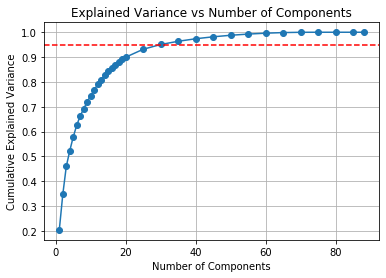

In [14]:
# Maximum number of components
max_comps = X.shape[1]

# Store explained variances for each number of components
explained_variances = []

# Create a combined range: 1-20, and then every 5th value after 20
components_range = list(range(1, 21)) + list(range(25, max_comps + 1, 5))
# Ensure max_comps is included if not already in the list
if max_comps not in components_range:
    components_range.append(max_comps)

for n in components_range:
    #print(f"{n}/{max_comps}")
    pca = PCA(n_components=n)
    pca.fit(X)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# Plot the cumulative explained variance
plt.plot(components_range, explained_variances, marker='o')
plt.axhline(y=0.95, linestyle="--", color='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()


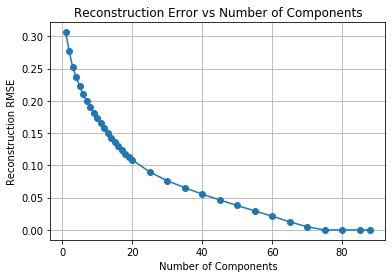

In [16]:
## 2. Reconstruction Error and RMSE

from sklearn.metrics import mean_squared_error

reconstruction_errors = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(X_reduced)
    rmse = np.sqrt(mean_squared_error(X, X_reconstructed))
    reconstruction_errors.append(rmse)

# Plot the reconstruction error
plt.plot(components_range, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction RMSE')
plt.title('Reconstruction Error vs Number of Components')
plt.grid(True)
plt.show()


In [28]:
## 3. Information-Theoretic Measures: Mutual Information and Entropy

from sklearn.feature_selection import mutual_info_regression

# Mutual Information
mutual_info_scores = []

X_npy = X.to_numpy()

for n in components_range:
    print(f"{n}/{max_comps}")
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X_npy)
    
    #mutual_info = np.mean([mutual_info_regression(X[:, i].reshape(-1, 1), X_reduced[:, j])[0] for i in range(X.shape[1]) for j in range(n)])
    #mutual_info_scores.append(mutual_info)
    total_mutual_info = 0
    count = 0
    for i in range(X_npy.shape[1]):  # Loop over each original feature
        for j in range(X_reduced.shape[1]):  # Loop over each reduced feature
            # Calculate mutual information between original feature i and reduced feature j
            mutual_info = mutual_info_regression(X_npy[:, i].reshape(-1, 1), X_reduced[:, j])
            total_mutual_info += mutual_info[0]
            count += 1
    # Calculate the average mutual information
    average_mutual_info = total_mutual_info / count
    mutual_info_scores.append(average_mutual_info)

# Plot the mutual information scores
plt.plot(components_range, mutual_info_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Average Mutual Information')
plt.title('Mutual Information vs Number of Components')
plt.grid(True)
plt.show()


1/88


KeyboardInterrupt: 

In [ ]:
assert(1==0)

I don't wanna run this one yet since it is doing a train test split... I'll manually do this later...

In [ ]:
## 4. Clustering and Classification Performance

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Clustering: Silhouette Score
silhouette_scores = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    # So it just totally randomly chose 3 here lol
    kmeans = KMeans(n_clusters=3)
    cluster_labels = kmeans.fit_predict(X_reduced)
    silhouette = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores.append(silhouette)

# Plot the silhouette scores
plt.plot(components_range, silhouette_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Components')
plt.grid(True)
plt.show()

# Classification: Accuracy and F1 Score
classification_accuracies = []
classification_f1_scores = []

# Assuming `y` is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# This actually did a train/test split... I should do this manually...
for n in components_range:
    pca = PCA(n_components=n)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    classification_accuracies.append(accuracy)
    classification_f1_scores.append(f1)

# Plot the classification accuracies
plt.plot(components_range, classification_accuracies, marker='o', label='Accuracy')
plt.plot(components_range, classification_f1_scores, marker='o', label='F1 Score')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('Classification Performance vs Number of Components')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
## Topological Measures: Neighborhood Preservation
# This one also uses an arbitrary number of clusters...

from sklearn.neighbors import NearestNeighbors

def knn_preservation_score(X_orig, X_reduced, k=5):
    knn_orig = NearestNeighbors(n_neighbors=k).fit(X_orig)
    knn_reduced = NearestNeighbors(n_neighbors=k).fit(X_reduced)
    neighbors_orig = knn_orig.kneighbors(X_orig, return_distance=False)
    neighbors_reduced = knn_reduced.kneighbors(X_reduced, return_distance=False)
    preservation = np.mean([len(set(neighbors_orig[i]).intersection(set(neighbors_reduced[i]))) / k for i in range(X_orig.shape[0])])
    return preservation

preservation_scores = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    score = knn_preservation_score(X, X_reduced)
    preservation_scores.append(score)

# Plot the neighborhood preservation scores
plt.plot(components_range, preservation_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Neighborhood Preservation Score')
plt.title('Neighborhood Preservation vs Number of Components')
plt.grid(True)
plt.show()


In [ ]:
## 7. Distance Metrics: Pairwise Distances
# This distance can only be used with matrices of the same size... so this doesn't work...

from scipy.spatial import procrustes

procrustes_distances = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    _, _, distance = procrustes(X, X_reduced)
    procrustes_distances.append(distance)

# Plot the Procrustes distances
plt.plot(components_range, procrustes_distances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Procrustes Distance')
plt.title('Procrustes Distance vs Number of Components')
plt.grid(True)
plt.show()

What is y... I don't have class labels...

In [ ]:
## 8. Cross-Validation Techniques

from sklearn.model_selection import cross_val_score

cv_accuracies = []

for n in components_range:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    clf = LogisticRegression(max_iter=1000)
    scores = cross_val_score(clf, X_reduced, y, cv=5, scoring='accuracy')
    cv_accuracies.append(np.mean(scores))

# Plot the cross-validation accuracies
plt.plot(components_range, cv_accuracies, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs Number of Components')
plt.grid(True)
plt.show()


## Application

## Choosing Optimal Number of Clusters

In [ ]:
assert(1==0)

> Elbow Plot

In [ ]:
from sklearn.cluster import KMeans

# determining the maximum number of clusters 
# using the simple method
limit = int((dataset_new.shape[0]//2)**0.5)
 
# wcss - within cluster sum of squared distances
wcss = {}
 
for k in range(2,limit+1):
    model = KMeans(n_clusters=k)
    model.fit(dataset_new)
    wcss[k] = model.inertia_
     
# plotting the wcss values to find the elbow value
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel('Values of "k"')
plt.ylabel('WCSS')
plt.show()

# determining the maximum number of clusters using the simple method
limit = int((dataset_new.shape[0]//2)**0.5)

> Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, limit+1):
	model = KMeans(n_clusters=k)
	model.fit(dataset_new)
	pred = model.predict(dataset_new)
	score = silhouette_score(dataset_new, pred)
	print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))